Import statements and LaTeX parameters:

In [10]:
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import eigh_tridiagonal
import matplotlib.ticker as ticker
from matplotlib.patches import Circle, Rectangle, Ellipse
from tqdm import tqdm
from matplotlib import cm
import warnings
from sympy import symbols, I, S, sqrt, limit, factorial, series, eye
from sympy.physics.matrices import msigma

latex_base_font_size = 10
captiong_font_size = 9

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": latex_base_font_size,
    "text.latex.preamble": r"""
        \usepackage{amsmath,amssymb}
        \usepackage{bm}
    """,
})


Fig. 1:

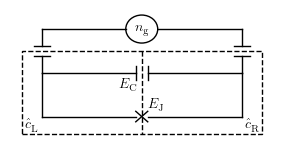

In [11]:
# === Figure generation ===

p = dict(left_x=0.25, right_x=0.75,
         top_y=0.50, bottom_y=0.375,
         cap_gap=0.03, cap_plate_h=0.02,
         jj_size=0.03, outer_y=0.625,
         volt_r=0.04, dashed_left=0.2, box_bottom=0.325,
         c_margin=0.0075, label_offset=0.035)

fig, ax = plt.subplots(figsize=(3.4, 1.7))

mid_x = (p['left_x'] + p['right_x'])/2
vline = lambda x,y0,y1,**k: ax.plot([x,x],[y0,y1],color='black',lw=1,**k)
hline = lambda x0,x1,y,**k: ax.plot([x0,x1],[y,y],color='black',lw=1,**k)

cl, cr = mid_x - p['cap_gap']/2, mid_x + p['cap_gap']/2

for x in (p['left_x'], p['right_x']): vline(x,p['bottom_y'],p['top_y'])
hline(p['left_x'], cl, p['top_y'])
hline(cr, p['right_x'], p['top_y'])
for x in (cl, cr): vline(x,p['top_y']-p['cap_plate_h'],p['top_y']+p['cap_plate_h'])
hline(p['left_x'], cl, p['bottom_y'])
ax.plot([cl, cr],[p['bottom_y']+p['jj_size']/2,p['bottom_y']-p['jj_size']/2],'k',lw=1)
ax.plot([cl, cr],[p['bottom_y']-p['jj_size']/2,p['bottom_y']+p['jj_size']/2],'k',lw=1)
hline(cr, p['right_x'], p['bottom_y'])

arm_len = p['outer_y'] - p['top_y']
cb = p['top_y'] + (arm_len - p['cap_gap'])/2
for x in (p['left_x'], p['right_x']):
    vline(x, p['top_y'], cb)
    for y in (cb, cb + p['cap_gap']):
        hline(x - p['cap_plate_h'], x + p['cap_plate_h'], y)
    vline(x, cb + p['cap_gap'], p['outer_y'])

hline(p['left_x'], mid_x - p['volt_r'], p['outer_y'])
hline(mid_x + p['volt_r'], p['right_x'], p['outer_y'])
ax.add_patch(Circle((mid_x, p['outer_y']), p['volt_r'], edgecolor='black', facecolor='none', lw=1))

dr = 1 - p['dashed_left']
cap_mid = cb + p['cap_gap']/2
ax.add_patch(Rectangle((p['dashed_left'], p['box_bottom']), dr - p['dashed_left'], cap_mid - p['box_bottom'], fill=False, linestyle='dashed', edgecolor='black', lw=1))
vline((p['dashed_left'] + dr)/2, cap_mid, p['box_bottom'], linestyle='dashed')

ax.text(mid_x, p['outer_y'], r'$n_{\text{g}}$', va='center', ha='center')
ax.text(mid_x - p['label_offset'], p['top_y'] - p['label_offset'], r'$E_\text{C}$', va='center', ha='center')
ax.text(mid_x + p['label_offset'], p['bottom_y'] + p['label_offset'], r'$E_\text{J}$', va='center', ha='center')
ax.text(dr - p['c_margin'], p['box_bottom'] + p['c_margin'], r'$\hat{c}^{}_\text{R}$', va='bottom', ha='right')
ax.text(p['dashed_left'] + p['c_margin'], p['box_bottom'] + p['c_margin'], r'$\hat{c}^{}_\text{L}$', va='bottom', ha='left')

ax.axis('off')
plt.savefig('fig1.pdf', bbox_inches='tight')
plt.show()


Fig. 2:

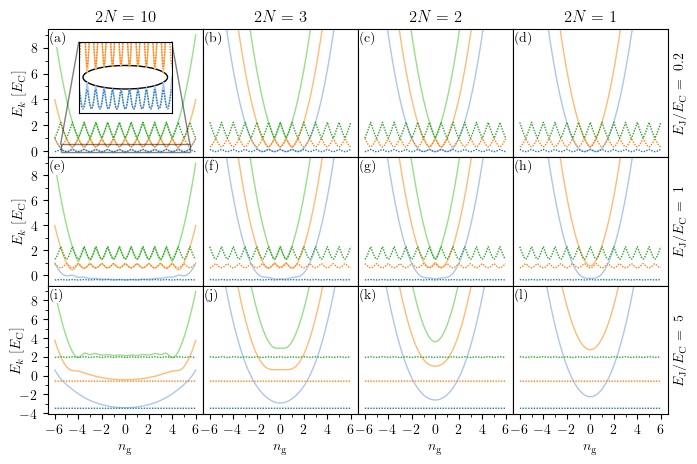

In [12]:
# === Data collection ==

session = WolframLanguageSession()
session.start()

def mathieu_a(r, q):
    return np.float64(session.function(wl.MathieuCharacteristicA)(r,q))

def mathieu_E(k,EC, EJ, ng):
    return (EC/4)*mathieu_a(k+1-np.mod(k+1,2) + 2*np.abs(np.mod(ng+1/2,1)-1/2)*(-1)**k,  -2*EJ/EC)

def E(k, EC, EJ, ng, N):
    D = EC * (np.arange(-N, N+1)-ng)**2
    O = -(EJ/2) * np.sqrt(1 - ((np.arange(-N, N) + 1/2)/N)**2)
    try:
        return eigh_tridiagonal(D, O, eigvals_only = True, select = 'i', select_range = (k, k))[0]
    except:
        return np.nan
    
def get_ngs_unit_cell(half_num_ngs_per_unit_cell):
    return np.linspace(0, 1, 2*half_num_ngs_per_unit_cell, endpoint = False)[1::2]

ngs_unit_cell = get_ngs_unit_cell(10**2)
num_unit_cells = 12
ngs = np.array([ngs_unit_cell + i for i in np.arange(-num_unit_cells // 2, num_unit_cells // 2)]).flatten()

Ns = [5, 3/2, 2/2, 1/2]
EJs = [0.2, 1, 5]
ks = [0,1,2]

bands = [[[] for _ in range(len(Ns))] for _ in range(len(EJs))]
mathieu_bands = [[[] for _ in range(len(Ns))] for _ in range(len(EJs))]
EC = 1

for i, EJ in enumerate(EJs):
    for j, N in enumerate(Ns):
        for k in ks:
            bands[i][j].append([E(k, EC, EJ, ng, N) for ng in ngs])
            parity = (1 - int(N==np.round(N)))
            mathieu_unit_cell = [mathieu_E(k, EC, EJ, ng-parity/2) for ng in ngs_unit_cell]
            mathieu_bands[i][j].append(mathieu_unit_cell*num_unit_cells)

session.stop()

# === Figure generation ====

fig_width_in_inches = 8  
fig_height_in_inches = 5.0 
fig, ax = plt.subplots(len(EJs), len(Ns), figsize = (fig_width_in_inches, fig_height_in_inches), sharex = True, sharey = 'row', gridspec_kw={'hspace': 0, 'wspace': 0})
colors = plt.colormaps["tab20"].colors

for i, EJ in enumerate(EJs):
    for j, N in enumerate(Ns):
        for k in ks:
            ax[i,j].plot(ngs, bands[i][j][k], lw = 1, color = colors[2*k+1])
            ax[i, j].plot(ngs, mathieu_bands[i][j][k], lw=1, ls=(0, (1, 1)), color=colors[2*k], dashes=(1, 1))
        if N == Ns[0]:
            ymin, ymax = ax[i,j].get_ylim()
        ax[i,j].set_ylim(ymin, ymax)

for i in range(len(EJs)):
    for j in range(len(Ns)):
            ax[i,j].set_yticks([])
            ax[i,j].set_xticks([])
            
for i in range(len(EJs)):
    for j in range(len(Ns)-1, -1, -1):
        if j == 0:
            ax[i, j].set_yticks([0, 2, 4, 6, 8] if i != 2 else [-4, -2, 0, 2, 4,6,8])
        else:
            ax[i, j].set_yticks([])
            ax[i, j].tick_params(axis='y', which='both', length=0)

for i in range(len(EJs)):
    if i != 2:
        ax[i,0].set_ylabel(r'$E_k~[E_\text{C}]$')
    else:
        ax[i,0].set_ylabel(r'$E_k~[E_\text{C}]$', labelpad = -2.5)
    ax[i,-1].set_ylabel(r'$E_\text{J}/E_\text{C}=~$' + rf'${EJs[i]}$')
    ax[i,-1].yaxis.set_label_position("right")
    ax[i,0].yaxis.set_minor_locator(ticker.MultipleLocator(1))

for j, N in enumerate(Ns):
    ax[-1,j].set_xlabel(r'$n_\text{g}$')
    ax[-1, j].set_xticks(np.arange(-Ns[0]-1,Ns[0]+2,2))
    ax[-1, j].xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax[0,j].set_title(fr'$2N={int(2*N)}$')

for i in range(len(EJs)):
    for j in range(len(Ns)):
        ax[i,j].text(0.015, .9, rf'({chr(97+i*len(Ns)+j)})', transform=ax[i,j].transAxes, bbox = dict(facecolor = 'white', edgecolor = 'none', boxstyle='square,pad=.1'))

N = Ns[0]
EJ = EJs[0]
axins = ax[0,0].inset_axes([0.2, 0.35, 0.6, 0.55], xlim = [-N-1/2, N+1/2], ylim = [.25-.3, .25+.3])
ax[0,0].indicate_inset_zoom(axins, edgecolor="black")
axins.plot(ngs, bands[0][0][0], lw = 1, color = colors[1])
axins.plot(ngs, mathieu_bands[0][0][0], lw = 1, ls = (0, (1, 1)), color = colors[0])
axins.plot(ngs, bands[0][0][1], lw = 1, color = colors[3])
axins.plot(ngs, mathieu_bands[0][0][1], lw = 1, ls = (0, (1, 1)), color = colors[2])
ellipse = Ellipse(xy = (0, 1/4), width= 2*N, height = EJ / EC, edgecolor='k', facecolor='none', lw=1)
axins.add_patch(ellipse)

axins.set_xticks([])
axins.set_yticks([])
axins.set_xlabel('')
axins.set_ylabel('')

plt.savefig('fig2.pdf', bbox_inches = 'tight', pad_inches=0.1)
plt.show()

Fig. 3:

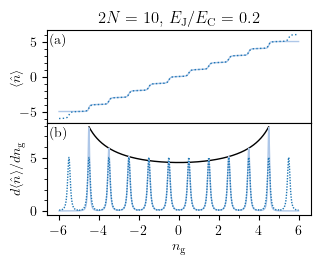

In [13]:
# === Data collection ===

warnings.filterwarnings('ignore')
session = WolframLanguageSession()
session.start()

def mathieu_a(r, q):
    return np.float64(session.function(wl.MathieuCharacteristicA)(r, q))

def mathieu_c(r, q, z):
    return np.float64(session.function(wl.MathieuC)(r, q, z))

def mathieu_s(r, q, z):
    return np.float64(session.function(wl.MathieuS)(r, q, z))

def mathieu_E(k, EC, EJ, ng):
    arg = k + 1 - np.mod(k+1, 2) + 2 * abs(np.mod(ng+0.5, 1) - 0.5) * (-1)**k
    return (EC/4) * mathieu_a(arg, -2*EJ/EC)

def mathieu_psi(k, EC, EJ, ng, theta):
    ng_mod = np.mod(ng + 0.5, 1) - 0.5
    base = np.exp(1j * abs(ng_mod) * theta) / np.sqrt(2*np.pi)
    c_part = mathieu_c(4*mathieu_E(k, EC, EJ, ng)/EC, -2*EJ/EC, theta/2)
    s_part = mathieu_s(4*mathieu_E(k, EC, EJ, ng)/EC, -2*EJ/EC, theta/2)
    psi = base * (c_part + 1j * (-1)**(k+1) * s_part)
    if ng_mod > 0:
        return psi * np.exp(1j * theta * (ng - ng_mod))
    else:
        return np.conj(psi) * np.exp(1j * theta * (ng - ng_mod))

def mathieu_avg_n(k, EC, EJ, ng, ntheta=100):
    thetas = np.linspace(-np.pi, np.pi, ntheta, endpoint=False)
    dtheta = thetas[1] - thetas[0]
    psi = np.array([mathieu_psi(k, EC, EJ, ng, th) for th in thetas])
    dpsi = (np.roll(psi, -1) - np.roll(psi, 1)) / (2*dtheta)
    integrand = np.conj(psi) * dpsi / 1j
    return np.sum(integrand) * dtheta

def E(k, EC, EJ, ng, N):
    D = EC * (np.arange(-N, N+1) - ng)**2
    n = np.arange(-N, N)
    O = -(EJ/(2*N)) * np.sqrt(N*(N+1) - n*(n+1))
    eigvals, eigvecs = eigh_tridiagonal(D, O, select='i', select_range=(k,k))
    v = eigvecs[:,0]
    return np.sum(v**2 * np.arange(-N, N+1)) / np.sum(v**2)

EC = 1
EJ = 0.2
N = 5
num_unit_cells = 12
half_nc = 100

def get_ngs_unit_cell(half_nc):
    return np.linspace(0, 1, 2*half_nc, endpoint=False)[1::2]

ngs_unit_cell = get_ngs_unit_cell(half_nc)
ngs = np.concatenate([ngs_unit_cell + i for i in range(-num_unit_cells//2, num_unit_cells//2)])

avg_ns = np.array([E(0, EC, EJ, ng, N) for ng in ngs])
parity = (1 - int(N == np.round(N)))
mathieu_base = np.array([mathieu_avg_n(0, EC, EJ, ng - parity/2) for ng in ngs_unit_cell])
mathieu_avg_ns = np.concatenate([mathieu_base + i for i in range(-num_unit_cells//2, num_unit_cells//2)])

session.stop()

# === Figure generation ===

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(3.4, 2.4), gridspec_kw={'hspace': 0})
colors = plt.colormaps["tab20"].colors
dx = ngs[1] - ngs[0]

ax[0].plot(ngs, avg_ns, lw=1, color=colors[1], label=r'$N<\infty$')
ax[0].plot(ngs, mathieu_avg_ns, lw=1, ls='dotted', color=colors[0], label=r'$N\rightarrow\infty$')
ax[0].set_ylabel(r'$\langle \hat{n} \rangle$', labelpad = -3)
ax[0].set_title(rf'$2N = {2*N}$, $E_\text{{J}}/E_\text{{C}} = {EJ/EC}$')

ax[1].plot(ngs, np.gradient(avg_ns, dx), lw=1, color=colors[1], label=r'$N<\infty$')
ax[1].plot(ngs, np.gradient(mathieu_avg_ns, dx), lw=1, ls=(0, (1, 1)), color=colors[0], label=r'$N\rightarrow\infty$')

cond = np.abs(ngs) < (N - 0.5)
ax[1].plot(ngs[cond], 2*N*EC/(EJ * np.sqrt((1+2*N)**2 - 4*ngs[cond]**2)), 'k', lw=1, zorder=-10)

ax[1].set_ylabel(r'$d\langle \hat{n} \rangle/dn_\text{g}$')
ax[1].set_xlabel(r'$n_\text{g}$')
ax[1].set_xticks(np.arange(-N-1, N+2, 2))
ax[1].xaxis.set_minor_locator(ticker.MultipleLocator(1))

ax[0].text(0.01, 0.85, '(a)', transform=ax[0].transAxes, bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=.1'))
ax[1].text(0.01, 0.85, '(b)', transform=ax[1].transAxes, bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=.1'))

for a in ax: a.yaxis.set_minor_locator(ticker.MultipleLocator(1))

plt.savefig("fig3.pdf", bbox_inches="tight")#, pad_inches=0)
plt.show()


Fig. 4:

100%|██████████| 6/6 [00:58<00:00,  9.81s/it]


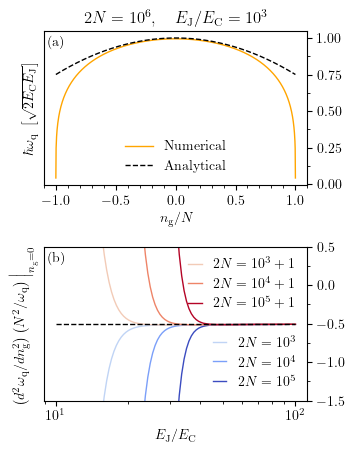

In [14]:
# === Data collection ===

def E(k, EC, EJ, ng, N):
    D = EC * (np.arange(-N, N+1)-ng)**2
    n = np.arange(-N, N)
    O = -(EJ/(2*N)) * np.sqrt(N*(N+1) - (n*(n+1)))
    eigs =  eigh_tridiagonal(D, O, eigvals_only = True, select = 'i', select_range = (k, k), tol = 1e-14)
    return eigs[0]

# "inset data"
EC=1
EJ=10**3
N=10**6 / 2
ngs = np.linspace(-N, N, 1000)
freqs = []
for ng in tqdm(ngs):
    freqs.append(E(k=1, EC=EC, EJ=EJ, ng=ng, N=N) - E(k=0, EC=EC, EJ=EJ, ng=ng, N=N))
inset_data = (ngs, freqs)
inset_N = N
inset_EC = EC
inset_EJ = EJ

# main data
EC=1
EJs = np.logspace(1, 2, 100)
exponents = [3,4,5]
EvenTwoNs = np.array([10**k for k in exponents])
Ns = np.concatenate((EvenTwoNs, EvenTwoNs + 1))/2
data = []
dng = 1e-1
for N in tqdm(Ns):
    data_N = []
    for EJ in EJs:
        freq_at_0 = E(k=1,EC=EC,EJ=EJ,ng=0,N=N)-E(k=0,EC=EC,EJ=EJ,ng=0, N=N)
        freq_at_dng = E(k=1,EC=EC,EJ=EJ,ng=dng,N=N)-E(k=0,EC=EC,EJ=EJ,ng=dng, N=N)
        curvature = 2*(freq_at_dng - freq_at_0) / dng**2
        asymptote=2*EC**2*np.sqrt(EJ)*(3*EJ*N-2*EC*N**3)/(EJ+2*EC*N**2)**(5/2)
        asymptote = 4*EC**2*np.sqrt(EJ)*N*(EJ-EC*N**2)/(EJ+2*EC*N**2)**(5/2)
        asymptote = 2*np.sqrt(2*EC*EJ)*(-(1/(2*N))**2)
        asymptote = freq_at_0 / ((N)**2)
        data_N.append(curvature/asymptote)
    data.append(data_N)

# === Figure generation ====

fig_width_in_inches = 3.4
fig_height_in_inches = 2.4*2

labels = [rf'$2N=10^{s}$' for s in exponents]
labels += [rf'$2N=10^{s}+1$' for s in exponents]

cmap = cm.get_cmap('coolwarm', len(labels))
colors = [cmap(i) for i in range(len(labels))]
eveng_colors = colors[0:len(colors)//2]
eveng_colors.reverse()
odd_colors = colors[len(colors)//2:]
colors = eveng_colors + odd_colors

fig, ax = plt.subplots(2, figsize = (fig_width_in_inches, fig_height_in_inches), gridspec_kw={'hspace':.4})
ax[0].plot(inset_data[0]/inset_N, inset_data[1]/np.sqrt(2*inset_EC*inset_EJ), color='orange', label='Numerical', lw=1)
ax[0].plot(inset_data[0]/inset_N, (1-(inset_data[0]/(2*inset_N))**2), linestyle = '--', color='k', markersize=3, label = 'Analytical', lw=1)
ax[0].legend(frameon=False)
ax[0].set_xlabel(r'$n_\mathrm{g}/N$')
ax[0].set_ylabel(r'$\hbar\omega_{\mathrm{q}}~\left[\sqrt{2E_{\mathrm{C}}E_{\mathrm{J}}}\right]$')
ax[0].set_title(r'$2N=10^6,\quad E_\mathrm{J}/E_\mathrm{C} = 10^3$')
ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(0.125))

even_handles = []
odd_handles = []

for i, data_N in enumerate(data):
    data_N = np.array(data_N)
    (line,) = ax[1].plot(EJs, data_N, label=labels[i], color=colors[i], lw=1)
    
    if i < len(labels)//2:
        even_handles.append(line)
    else:
        odd_handles.append(line)

ax[1].plot(EJs, -np.ones_like(EJs)/2, linestyle='--', color='k', lw=1)

legend1 = ax[1].legend(handles=even_handles, loc='lower right', frameon=False, handlelength = 1)
legend2 = ax[1].legend(handles=odd_handles, loc='upper right', frameon=False, handlelength = 1)
ax[1].add_artist(legend1)

ax[1].set_xscale('log')
ax[1].set_ylim(-1.5, 0.5)
ax[1].set_yticks([-1.5, -1, -.5, 0, .5])
ax[1].set_ylabel(r'$\left(d^2\omega_\mathrm{q}/dn_\mathrm{g}^2\right)\left(N^2/\omega_\mathrm{q}\right)\Big|_{n_\mathrm{g}=0}$')
ax[1].set_xlabel(r'$E_\mathrm{J}/E_\mathrm{C}$')
ax[1].yaxis.set_minor_locator(ticker.MultipleLocator(0.25))

ax[0].text(0.015, 0.9, '(a)', transform=ax[0].transAxes, bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=.1'))
ax[1].text(0.015, 0.9, '(b)', transform=ax[1].transAxes, bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=.1'))

ax[0].yaxis.tick_right()
ax[1].yaxis.tick_right()

plt.savefig('fig4.pdf', bbox_inches='tight')
plt.show()

Fig. 5:

100%|██████████| 4/4 [00:00<00:00, 16.11it/s]


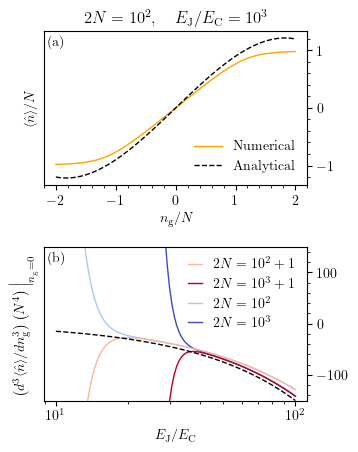

In [15]:
# === Data collection ===

def avg_n(k, EC, EJ, ng, N):
    D = EC * (np.arange(-N, N+1, dtype = np.float64)-ng)**2
    n = np.arange(-N, N, dtype = np.float64)
    O = -(EJ/(2*N)) * np.sqrt(N*(N+1) - (n*(n+1)))    
    _, v =  eigh_tridiagonal(D, O, select = 'i', select_range = (k, k), tol = 1e-16)
    return np.sum(np.abs(v[:,0])**2*np.arange(-N, N+1))#/np.sum(np.abs(v[:,0])**2)
def E(k, EC, EJ, ng, N):
    D = EC * (np.arange(-N, N+1)-ng)**2
    n = np.arange(-N, N)
    O = -(EJ/(2*N)) * np.sqrt(N*(N+1) - (n*(n+1)))
    eigs =  eigh_tridiagonal(D, O, eigvals_only = True, select = 'i', select_range = (k, k), tol = 1e-14)
    return eigs[0]

# "inset" data
EC=1
EJ=10**3
N=10**2 / 2
ngs = np.linspace(-2*N, 2*N, 100)
avg_ns = []
for ng in tqdm(ngs):
    avg_ns.append(avg_n(0, EC, EJ, ng, N)/N)
inset_data = (ngs, avg_ns)
inset_N = N
inset_EC = EC
inset_EJ = EJ

# main data
d3 = lambda N, EJ: (-2 * avg_n(0, EC, EJ, dng, N) + avg_n(0, EC, EJ, 2*dng, N)) / dng**3 # third derivative
EJs = np.logspace(1, 2, 100)
exponents = [2,3]
EvenTwoNs = np.array([10**k for k in exponents])
Ns = np.concatenate((EvenTwoNs, EvenTwoNs + 1))/2
data = []
dng = 1e-1
for N in tqdm(Ns):
    data_N = [N**4*d3(N, EJ) for EJ in EJs]
    data.append(data_N)

# === Figure generation ====

fig_width_in_inches = 3.4
fig_height_in_inches = 2.4*2

labels = [rf'$2N=10^{s}$' for s in exponents]
labels += [rf'$2N=10^{s}+1$' for s in exponents]

cmap = cm.get_cmap('coolwarm', len(labels))
colors = [cmap(i) for i in range(len(labels))]
eveng_colors = colors[0:len(colors)//2] 
eveng_colors.reverse() 
odd_colors = colors[len(colors)//2:]
colors = eveng_colors + odd_colors

fig, ax = plt.subplots(2, figsize = (fig_width_in_inches, fig_height_in_inches), gridspec_kw={'hspace':.4})
ax[0].plot(inset_data[0]/inset_N, inset_data[1], color='orange', label='Numerical', lw=1)
ax[0].plot(inset_data[0]/inset_N, (inset_data[0] - (inset_EJ/(4*inset_EC*inset_N**4))*inset_data[0]**3)/inset_N, linestyle = '--', color='k', markersize=3, label = 'Analytical', lw=1)
ax[0].legend(frameon=False)
ax[0].set_xlabel(r'$n_\mathrm{g}/N$')
ax[0].set_ylabel(r'$\langle\hat{n}\rangle/N$')
ax[0].set_title(r'$2N=10^2,\quad E_\mathrm{J}/E_\mathrm{C} = 10^3$')
ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(0.2))

even_handles = []
odd_handles = []

for i, data_N in enumerate(data):
    data_N = np.array(data_N)
    (line,) = ax[1].plot(EJs, data_N, label=labels[i], color=colors[i], lw=1)
    if i < len(labels)//2:
        even_handles.append(line)
    else:
        odd_handles.append(line)
    
ax[1].plot(EJs, (-(3/2)*(EJs/EC)), linestyle='--', color='k', lw=1)

legend2 = ax[1].legend(handles=(odd_handles+even_handles), loc='upper right', frameon=False, handlelength = 1)

ax[1].set_xscale('log')
ax[1].set_ylim((-3/2)*100, (3/2)*100)
ax[1].set_ylabel(r'$\left(d^3\langle\hat{n}\rangle/dn_\mathrm{g}^3\right)\left(N^4\right)\Big|_{n_\mathrm{g}=0}$')
ax[1].set_xlabel(r'$E_\mathrm{J}/E_\mathrm{C}$')
ax[1].yaxis.set_minor_locator(ticker.MultipleLocator(20))

ax[0].text(0.015, 0.9, '(a)', transform=ax[0].transAxes, bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=.1'))
ax[1].text(0.015, 0.9, '(b)', transform=ax[1].transAxes, bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=.1'))

ax[0].yaxis.tick_right()
ax[1].yaxis.tick_right()
plt.savefig('fig5.pdf', bbox_inches='tight')
plt.show()


Eqs. (7) and (14):

In [16]:
# === Hamiltonian definition ===
sx = msigma(1)
sz = msigma(3)
ng_f, ng_c, ng = symbols("ng_f, ng_c, n_\mathrm{g}") # floor, ceiling, offset charge
EC, EJ, N = symbols("E_\mathrm{C}, E_\mathrm{J}, N", positive = True)
n = eye(2)*(ng_f+ng_c)/2 + (ng_f-ng_c)/2 * sz
H=EC*(n - eye(2)*ng)**2 - (EJ/(2*N))*sqrt(N*(N+1)-ng_f*ng_c)*sx

# === Eq. (7) ===
eigenvalues = list(H.eigenvals().keys())
freq = (eigenvalues[1] - eigenvalues[0]).subs(ng_f,ng-1/S(2)).subs(ng_c, ng+1/S(2)).simplify()
print('Cooper pair box frequency times Planck\'s constant:')
display(freq)

# === Eq. (14) ===
ground = H.eigenvects()[0][2][0]
suscept = (ground.dot(n @ ground)/(ground.dot(ground))).diff(ng).subs(ng_f, ng-1/S(2)).subs(ng_c, ng+1/S(2)).simplify()
print('Cooper pair box dimensionless charge susceptibility:')
display(suscept)

Cooper pair box frequency times Planck's constant:


E_\mathrm{J}*sqrt(4*N**2 + 4*N - 4*n_\mathrm{g}**2 + 1)/(2*N)

Cooper pair box dimensionless charge susceptibility:


2*E_\mathrm{C}*N/(E_\mathrm{J}*sqrt(4*N**2 + 4*N - 4*n_\mathrm{g}**2 + 1))

Eqs. (13) and (17):

In [17]:
# === Contraction algorithm for evaluation of vacuum expectation values ===

def pairwise_product(term1, term2):
    result = []
    for (coeff1, bstring1) in term1:
        for (coeff2, bstring2) in term2:
            result.append((coeff1*coeff2, bstring1+bstring2))
    return result

def product(terms):
    if len(terms) == 1:
        return terms[0]
    else:
        return product([pairwise_product(terms[0], terms[1]), ] + terms[2:])

# 0 is b, 1 is b^\dagger
def contract(worklist):
    worklist = worklist.copy()
    result = []
    while worklist:
        coeff, bstring = worklist.pop()
        if bstring == "":
            result.append(coeff)
        elif bstring[-1] == "0" or bstring[0] == "1":
            continue
        else:
            index = bstring.find("01")
            before = bstring[:index]
            after = bstring[index+2:]
            worklist.append((coeff, before+after))
            worklist.append((coeff, (before+"10"+after)))
    return sum(result)

def scale(op, scalar):
    return product([op, [(scalar, "")]])

# === Affine Bogoliubov transformation given by Eq. (12) and surrounding discussion ===

ng = symbols("n_\mathrm{g}")
N, EJ, EC = symbols("N E_\mathrm{J} E_\mathrm{C}", positive = True)
u_s, u_p, u_m, u_0 = symbols("u_s, u_p, u_m u_0")
b = [(1,"0")]
bd = [(1,"1")]
a = [(u_p, "0"), (-u_m, "1"), (I * u_0 * u_s, "")]
ad = [(u_p, "1"), (-u_m, "0"), (-I * u_0 * u_s, "")]
p = scale(a + scale(ad, -1), 1/(I*sqrt(2)))
pp = p + [(-ng/sqrt(N), "")]

eps = sqrt(2*EC*EJ + EJ**2/N**2)
u_p_sub = (EJ + N * eps) / sqrt(4 * N * eps * EJ)
u_m_sub = (EJ - N * eps) / sqrt(4 * N * eps * EJ)
u_0_sub = ng * sqrt(2 * EC**2 * EJ / eps**3)
u_s_sub = u_p_sub + u_m_sub

# === Eq. (13) ===

x = symbols('x')
freq = eps - (EC/2)*(contract(product([b, pp, ad, p, a, bd])) - contract(product([pp, ad, p, a])))
freq = freq.subs({u_p: u_p_sub, u_m: u_m_sub, u_0: u_0_sub, u_s: u_s_sub, }).simplify()
assert((freq - series(freq, ng, 0, 3)).simplify()==0)
assert(freq.diff(ng).subs(ng,0)==0)
freq_0 = limit(freq.subs(ng, 0).subs(N, x * EJ/EC), x, "oo")
freq_2 = limit((N**2 * (freq.diff(ng, 2)/2).subs(ng, 0)).subs(N, x * EJ/EC), x, "oo")*(ng/N)**2
freq = (limit(((freq_0+freq_2)/sqrt(EC * EJ)).subs(EC, x * EJ), x, 0) * sqrt(EC * EJ)).simplify()
print('Transmon qubit frequency times Planck\'s constant:')
display(freq)

# === Eq. (17) ===

zeroth_order = (sqrt(N)*contract(p))
first_order = ((-1/(4*sqrt(N)))*contract(product([ad, p, a])))
for k in range(1,5):
    first_order += EC*sqrt(N)/(2*eps*k*factorial(k)) * contract(product([p] + [bd] * k)) * (contract(product([b] * k + [pp, ad, p, a])) + contract(product([b] * k + [ad, p, a, pp])))
all_orders = (zeroth_order + first_order).subs({u_p: u_p_sub, u_m: u_m_sub, u_0: u_0_sub, u_s: u_s_sub}).simplify()
all_orders.diff(ng, 3).subs(ng, 0).simplify()
suscept = all_orders.diff(ng)
assert((suscept - series(suscept, ng, 0, 3)).simplify() == 0)
assert(suscept.diff(ng).subs(ng, 0) == 0)
suscept_0 = limit(suscept.subs(ng, 0).subs(N, x * EJ/EC), x, "oo")
suscept_2 = limit((N**4 * (suscept.diff(ng, 2)/2).subs(ng, 0)).subs(N, x * EJ/EC), x, "oo")*(ng**2)/(N**4)
suscept = suscept_0 + suscept_2
print('Transmon dimensionless charge susceptibility:')
display(suscept.simplify())


Transmon qubit frequency times Planck's constant:


sqrt(2)*sqrt(E_\mathrm{C})*sqrt(E_\mathrm{J})*(N**2 - n_\mathrm{g}**2/4)/N**2

Transmon dimensionless charge susceptibility:


1 - 3*E_\mathrm{J}*n_\mathrm{g}**2/(4*E_\mathrm{C}*N**4)